In [1]:
import pandas as pd
import graphviz
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import sklearn 
import numpy as np
import matplotlib.pyplot as plt

First, load the data and the corresponding classes as pandas tables. We have the data of 200 patients.

The first column of the data corresponds to the age of the patients, the second one to the HbA1C value, the third one gives indication if insulin was taken, and the fourth one gives indication if any other drug was taken.

Class 0 means diabetes remission, class 1 means non-remission.



In [2]:
data_diabetes = pd.read_table("patients_data.txt",sep="\t",header=None)
classes_diabetes = pd.read_table("patients_classes.txt",sep="\t",header=None)
data_diabetes,classes_diabetes

(             0          1  2  3
 0    51.650893   9.679493  0  0
 1    64.627752   7.970522  0  1
 2    69.550752   6.368363  1  0
 3    65.270695   8.812844  0  1
 4    62.681176  10.322206  1  1
 ..         ...        ... .. ..
 195  45.200346   7.315751  0  1
 196  46.261624   6.520131  0  0
 197  41.424692   5.772244  0  1
 198  43.681741   7.993931  0  1
 199  62.970023   5.466263  1  0
 
 [200 rows x 4 columns],
      0
 0    1
 1    1
 2    1
 3    1
 4    1
 ..  ..
 195  0
 196  0
 197  0
 198  0
 199  0
 
 [200 rows x 1 columns])

Now, we fit a decision tree to the data and visualise the resulting tree in a .pdf file. 

One can also limit the depth of the decision tree, so that the visualisation of the tree is clearer.

In [3]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data_diabetes, classes_diabetes)
feature_names = ["age", "hba1c", "insuline taken", "other drugs taken"]
classes = ["DR","NDR"]
dot_data = tree.export_graphviz(clf, 
                                out_file=None,
                                feature_names=feature_names,
                                class_names=classes,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("diabetes remission") 

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(data_diabetes, classes_diabetes)
dot_data = tree.export_graphviz(clf, 
                                out_file=None,
                                feature_names=feature_names,
                                class_names=classes,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("diabetes remission_depth_limit") 

'diabetes remission_depth_limit.pdf'

In the next cell, we use a random forest as a classifier. Then we visualize the importance of the four features.

We can conclude that the age of a patient and the fact if insuline was already taken is most important for the classification.

Text(0.5, 1.0, 'Feature importances')

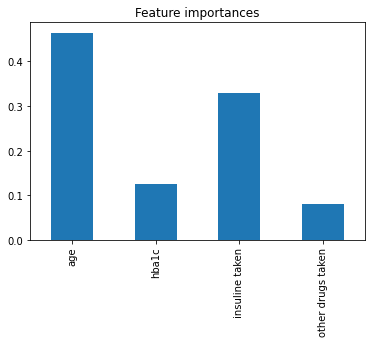

In [4]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(data_diabetes, np.squeeze(classes_diabetes))
forest_importances = pd.Series(clf.feature_importances_, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")

In the following cell, the DiaRem score model is implemented.

In [6]:
score=np.zeros(200)
for i in range(200):

    #Score for the age
    if data_diabetes.iloc[i][0]<40:
        score[i]+=0
    elif data_diabetes.iloc[i][0]>=40 and data_diabetes.iloc[0][0]<50:
        score[i]+=1
    elif data_diabetes.iloc[i][0]>=50 and data_diabetes.iloc[0][0]<60:
        score[i]+=2
    elif data_diabetes.iloc[i][0]>=60:
        score[i]+=3
    
    #Score for the HbA1C value
    if data_diabetes.iloc[i][1]<6.5:
        score[i]+=0
    elif data_diabetes.iloc[i][1]>=6.5 and data_diabetes.iloc[0][0]<7:
        score[i]+=2
    elif data_diabetes.iloc[i][1]>=7 and data_diabetes.iloc[0][0]<9:
        score[i]+=4
    elif data_diabetes.iloc[i][1]>=9:
        score[i]+=6

    #Score if insuline was taken
    if data_diabetes.iloc[i][2]==1:
        score[i]+=10
    elif data_diabetes.iloc[i][2]==0:
        score[i]+=0

    #Score if any other drug was taken
    if data_diabetes.iloc[i][3]==1:
        score[i]+=3
    elif data_diabetes.iloc[i][3]==0:
        score[i]+=0

#Patient having diabetes remission if the score is smaller than 7
predictions_DiaRem=np.zeros(200)
for i in range(200):
    if score[i]<7:
        predictions_DiaRem[i]=0
    else:
        predictions_DiaRem[i]=1

For the comparison of the predictive accuracy of these three models, we use the mean of a 5-fold cross validation for the decision tree and random forest. By this technique, we take a test set into account. However, if we just fix one test set randomly, then the accuracy can vary a lot depending on the choice of test set since the dataset is relatively small (200 patients). Therefore, I decided to use cross-validation.

In [11]:
clf = tree.DecisionTreeClassifier()
acc_dectree=sklearn.model_selection.cross_val_score(clf,data_diabetes,np.squeeze(classes_diabetes),cv=5).mean()
print("Decision tree accuracy without depth limit: ",acc_dectree)

clf = tree.DecisionTreeClassifier(max_depth=2)
acc_dectree=sklearn.model_selection.cross_val_score(clf,data_diabetes,np.squeeze(classes_diabetes),cv=5).mean()
print("Decision tree accuracy with depth 2: ",acc_dectree)

clf = RandomForestClassifier(max_depth=2, random_state=0)
acc_rf=sklearn.model_selection.cross_val_score(clf,data_diabetes,np.squeeze(classes_diabetes),cv=5).mean()
print("Random forest accuracy: ",acc_rf)

acc_diarem_all=sklearn.metrics.accuracy_score(classes_diabetes,predictions_DiaRem)
print("DiaRem accuracy: ",acc_diarem_all)

Decision tree accuracy without depth limit:  0.6950000000000001
Decision tree accuracy with depth 2:  0.655
Random forest accuracy:  0.775
DiaRem accuracy:  0.755


Overall, one can conclude that the random forest clearly outperforms a single decision tree. The random forest and the DiaRem model have comparable accuracy, the random forest is slightly better. However, the DiaRem model does not learn anything in contrast to random forest and is interpretable.